In [1]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.16.1


In [2]:
!pip install tfa-nightly keras_cv 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 620.3/620.3 kB 9.7 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.3.0
    Uninstalling typeguard-4.3.0:
      Successfully uninstalled typeguard-4.3.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
ydata-profiling 4.12.0 requires scipy<1.14,>=1.4.1, but you have scipy 1.14.1 which is incompatible.
ydata-profiling 4.12.0 requires typeguard<5,>=3, but you have typeguard 2.13.3 which is incompatible.


In [3]:
# Set batch size for training
BATCH_SIZE = 512

# Set learning rate for the optimiser
LEARNING_RATE = 1e-4

# Set early stopping patience threshold
PATIENCE = 50

# Set maximum number of training epochs
EPOCHS = 1000

NUM_CLASSES=5

In [4]:
import numpy as np

data = np.load("/kaggle/input/mars-dataset/mars_for_students.npz")
training_set = data["training_set"]

X_train = training_set[:, 0]
y_train = training_set[:, 1]

X_test = data["test_set"]

## Data cleaning

In [5]:
# Get the reference label (y_train[62])
reference_label = y_train[62]

# Filter the dataset where y_train is not equal to the reference label
mask = [not np.array_equal(label, reference_label) for label in y_train]

print(f"Original dataset size: {len(X_train)}")

X_train = X_train[mask]
y_train = y_train[mask]

print(f"Filtered dataset size: {len(X_train)}")

Original dataset size: 2615
Filtered dataset size: 2505


Img 0


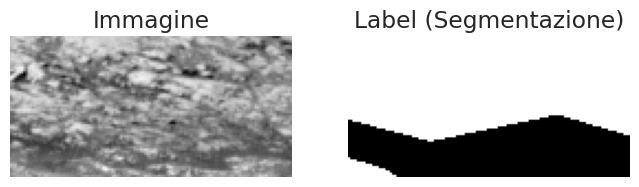

Img 1


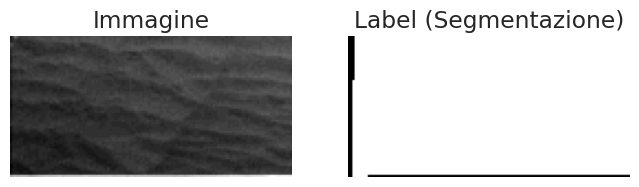

Img 2


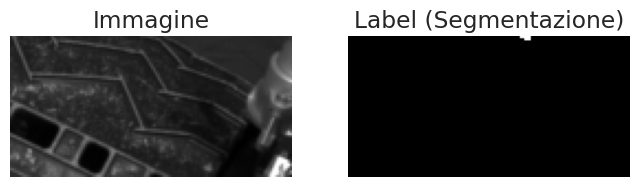

Img 3


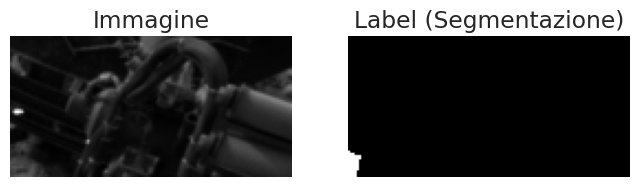

Img 4


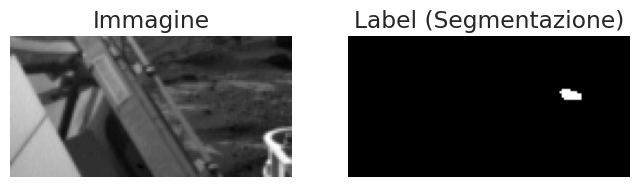

Img 5


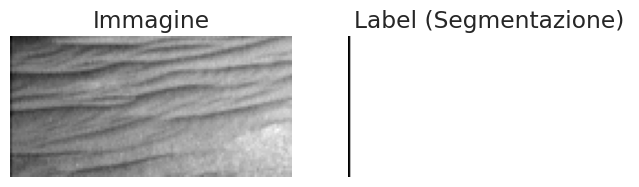

Img 6


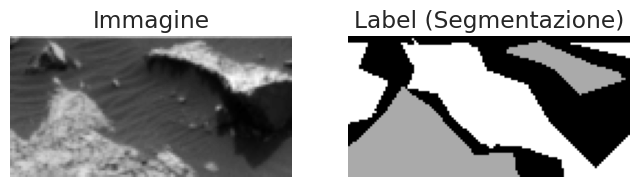

Img 7


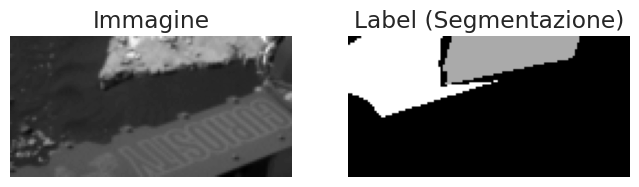

Img 8


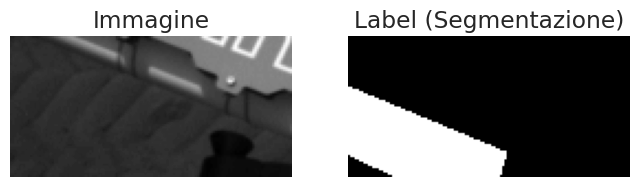

Img 9


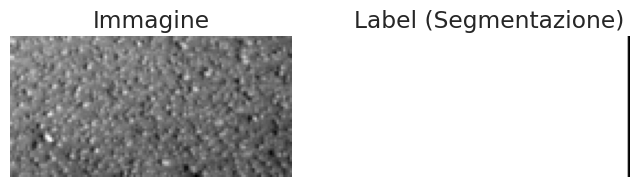

Img 10


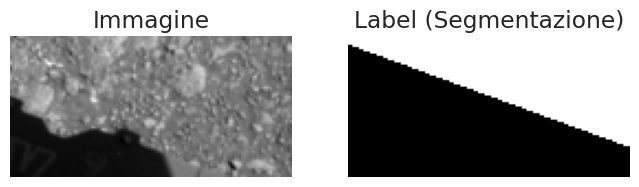

In [6]:
import matplotlib.pyplot as plt

# Supponiamo che X_train contenga le immagini e y_train le etichette di segmentazione
for i, (img, label) in enumerate(zip(X_train, y_train)):
    plt.figure(figsize=(8, 4))
    
    print("Img " + str(i))
    
    # Immagine originale
    plt.subplot(1, 2, 1)
    plt.imshow(img, cmap='gray' if len(img.shape) == 2 else None)
    plt.title("Immagine")
    plt.axis('off')
    
    # Label di segmentazione
    plt.subplot(1, 2, 2)
    plt.imshow(label, cmap='gray' if len(label.shape) == 2 else None)
    plt.title("Label (Segmentazione)")
    plt.axis('off')
    
    plt.show()

    
    # Limita il numero di immagini mostrate, ad esempio a 10
    if i >= 10:
        break


In [7]:
# Flatten y_train to aggregate pixel counts across all images
all_pixels = np.concatenate([y.flatten() for y in y_train])

# Count the occurrences of each class
unique_classes, counts = np.unique(all_pixels, return_counts=True)

# Calculate the total number of pixels
total_pixels = all_pixels.size

# Calculate the percentage of each class
class_percentages = {cls: (count / total_pixels) * 100 for cls, count in zip(unique_classes, counts)}

# Print results
print("Class percentages:")
for cls, percentage in class_percentages.items():
    print(f"Class {cls}: {percentage:.2f}%")

Class percentages:
Class 0.0: 24.31%
Class 1.0: 33.90%
Class 2.0: 23.28%
Class 3.0: 18.38%
Class 4.0: 0.13%


In [8]:
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.1, random_state=seed
)

In [9]:
from tensorflow.keras.layers import GlobalAveragePooling2D, Reshape, Dense, Multiply, concatenate

def unet_block(input_tensor, filters, kernel_size=3, activation='relu', stack=2, name=''):
    # Initialise the input tensor
    x = input_tensor

    # Apply a sequence of Conv2D, Batch Normalisation, and Activation layers for the specified number of stacks
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)

    # Return the transformed tensor
    return x

def attention_gate(skip_connection, gating_signal, inter_channels):
    # Riduzione dimensionale
    theta_x = tfkl.Conv2D(inter_channels, (1, 1), padding="same")(skip_connection)  # Da skip
    phi_g = tfkl.Conv2D(inter_channels, (1, 1), padding="same")(gating_signal)      # Da upsample
    # Somma e attivazione ReLU
    f = tfkl.Activation("relu")(tfkl.Add()([theta_x, phi_g]))
    # Maschera di attenzione
    psi = tfkl.Conv2D(1, (1, 1), padding="same", activation="sigmoid")(f)
    # Applicazione della maschera
    return tfkl.Multiply()([skip_connection, psi])
    
class AttentionBlock(tfkl.Layer):
    def __init__(self, filters, name='attention_block', **kwargs):
        super(AttentionBlock, self).__init__(name=name, **kwargs)
        self.filters = filters
        self.query_conv = tfkl.Conv2D(filters, kernel_size=1, name=name + '_query')
        self.key_conv = tfkl.Conv2D(filters, kernel_size=1, name=name + '_key')
        self.value_conv = tfkl.Conv2D(filters, kernel_size=1, name=name + '_value')
        self.add = tfkl.Add(name=name + '_add')

    def call(self, inputs):
        query = self.query_conv(inputs)
        key = self.key_conv(inputs)
        value = self.value_conv(inputs)

        batch_size = tf.shape(query)[0]
        query = tf.reshape(query, [batch_size, -1, self.filters])
        key = tf.reshape(key, [batch_size, -1, self.filters])
        value = tf.reshape(value, [batch_size, -1, self.filters])

        attention_scores = tf.nn.softmax(tf.matmul(query, key, transpose_b=True), axis=-1)
        attention_output = tf.matmul(attention_scores, value)
        attention_output = tf.reshape(attention_output, tf.shape(inputs))

        return self.add([inputs, attention_output])


# Definizione dell'ASPP Block
def aspp_block(input_tensor, filters, name=''):
    # Convoluzione a 1x1
    conv1 = tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same', name=name + '_conv1')(input_tensor)
    
    # Convoluzioni dilatate (differenti tassi di dilatazione)
    conv2 = tf.keras.layers.Conv2D(filters, kernel_size=3, dilation_rate=6, padding='same', name=name + '_conv2')(input_tensor)
    conv3 = tf.keras.layers.Conv2D(filters, kernel_size=3, dilation_rate=12, padding='same', name=name + '_conv3')(input_tensor)
    conv4 = tf.keras.layers.Conv2D(filters, kernel_size=3, dilation_rate=18, padding='same', name=name + '_conv4')(input_tensor)
    
    # Pooling globale
    pool = tf.keras.layers.GlobalAveragePooling2D()(input_tensor)
    pool = tf.keras.layers.Reshape((1, 1, filters))(pool)
    pool = tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same', name=name + '_pool_conv')(pool)
    pool = tf.keras.layers.UpSampling2D(size=(input_tensor.shape[1], input_tensor.shape[2]), interpolation='bilinear')(pool)
    
    # Concatenazione dei risultati
    concatenated = tf.keras.layers.Concatenate()([conv1, conv2, conv3, conv4, pool])
    
    # Convoluzione finale per ridurre la dimensionalità
    output = tf.keras.layers.Conv2D(filters, kernel_size=1, padding='same', name=name + '_output')(concatenated)
    
    return output
    
def global_context_module(x, channels):
    # Global Average Pooling (GAP) per ottenere un vettore globale di dimensione [batch_size, channels]
    gap = GlobalAveragePooling2D()(x)
    
    # Reshape per preparare il vettore in modo che possa essere utilizzato per la moltiplicazione
    gap = Reshape((1, 1, channels))(gap)
    
    # Convoluzione o MLP per arricchire il contesto globale (facoltativo)
    # In questo esempio, usiamo un layer Dense seguito da una convoluzione
    gap = Dense(channels // 8, activation='relu')(gap)
    gap = Dense(channels, activation='sigmoid')(gap)
    
    # Moltiplicazione elemento per elemento del contesto globale con l'input
    x = Multiply()([x, gap])
    
    return x

In [10]:
import keras_cv

def augmentation_layer():
    return tf.keras.Sequential([
        tf.keras.layers.RandomBrightness(0.1),
        keras_cv.layers.RandomContrast([0, 255], 0.1),
        keras_cv.layers.RandomGaussianBlur(2, 1),
        tf.keras.layers.GaussianNoise(0.02)
    ])
    
def get_unet_model(input_shape=(64, 128, 1), num_classes=NUM_CLASSES, seed=seed, name="UNet"):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    input_layer = augmentation_layer()(input_layer)

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    down_block_3 = unet_block(d2, 128, name='down_block3_')  # Additional downsampling block
    d3 = tfkl.MaxPooling2D()(down_block_3)

    down_block_4 = unet_block(d3, 256, name='down_block4_')  # Another additional downsampling block
    d4 = tfkl.MaxPooling2D()(down_block_4)
    
    # Bottleneck
    bottleneck = unet_block(d4, 512, stack=5, name='bottleneck')
    
    # Applicazione del blocco ASPP
    aspp_output = aspp_block(bottleneck, 512, name='aspp_block')
    
    # Applicazione del Global Context Module sul bottleneck (o su aspp_output, a seconda delle necessità)
    bottleneck_with_context = global_context_module(bottleneck, 512)
    
    # Concatenazione dell'output del GCM con il risultato di ASPP (o bottleneck)
    concatenated_output = concatenate([bottleneck_with_context, aspp_output], axis=-1)
    
    # Blocco di attenzione sul risultato concatenato
    bottleneck_with_attention = AttentionBlock(512, name=name + 'attention')(concatenated_output)

    # Upsampling path
    u4 = tfkl.UpSampling2D()(bottleneck)
    att4 = attention_gate(down_block_4, u4, inter_channels=128)  # Attention gate
    u4 = tfkl.Concatenate()([u4, att4])
    u4 = unet_block(u4, 256, name='up_block4_')

    u3 = tfkl.UpSampling2D()(u4)
    att3 = attention_gate(down_block_3, u3, inter_channels=64)  # Attention gate
    u3 = tfkl.Concatenate()([u3, att3])
    u3 = unet_block(u3, 128, name='up_block3_')

    u2 = tfkl.UpSampling2D()(u3)
    att2 = attention_gate(down_block_2, u2, inter_channels=32)
    u2 = tfkl.Concatenate()([u2, att2])
    u2 = unet_block(u2, 64, name='up_block2_')

    u1 = tfkl.UpSampling2D()(u2)
    att1 = attention_gate(down_block_1, u1, inter_channels=16)
    u1 = tfkl.Concatenate()([u1, att1])
    u1 = unet_block(u1, 32, name='up_block1_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u1)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name=name)
    return model

In [11]:
category_map = {
        0: 0,  # unlabelled
        1: 1,
        2: 2,
        3: 3,
        4: 4
}
    
def apply_category_mapping(label):
    """
    Apply category mapping to labels.
    """
    keys_tensor = tf.constant(list(category_map.keys()), dtype=tf.int32)
    vals_tensor = tf.constant(list(category_map.values()), dtype=tf.int32)
    table = tf.lookup.StaticHashTable(
        tf.lookup.KeyValueTensorInitializer(keys_tensor, vals_tensor),
        default_value=0
    )
    return table.lookup(int(label))

In [12]:
import tensorflow_addons as tfa
import random

    
def rotate_fn(im, label):
    angolo = random.randint(-90, 90)

    # Otteniamo le dimensioni originali dell'immagine
    altezza, larghezza = im.shape[:2]
    
    # Calcoliamo il centro dell'immagine
    centro = (larghezza // 2, altezza // 2)
    
    # Calcoliamo la matrice di rotazione
    matrice_rotazione = cv2.getRotationMatrix2D(centro,angolo, 1.0)
    
    # Aggiustiamo la matrice per mantenere la stessa dimensione dell'immagine
    matrice_rotazione[0, 2] += (larghezza / 2) - centro[0]
    matrice_rotazione[1, 2] += (altezza / 2) - centro[1]
    
    # Ruotiamo l'immagine usando la matrice di rotazione
    immagine_ruotata = cv2.warpAffine(im, matrice_rotazione, (larghezza, altezza), flags=cv2.INTER_LINEAR)
    label_ruotata = cv2.warpAffine(label, matrice_rotazione, (larghezza, altezza), flags=cv2.INTER_LINEAR)

    return immagine_ruotata, label_ruotata



def translate_fn(image, label, shift_x, shift_y):
    # Crea una matrice affine di traslazione (3x3)
    translation_matrix = tf.convert_to_tensor([
        [1.0, 0.0, shift_x],
        [0.0, 1.0, shift_y],
        [0.0, 0.0, 1.0]
    ], dtype=tf.float32)

    # Convertiamo la matrice 3x3 in un array di 8 valori (trasformazione affine)
    affine_transform = tf.reshape(translation_matrix[:-1, :-1], [-1])  # Escludiamo l'ultima riga e colonna
    
    # Ruotare l'immagine e l'etichetta usando tfa.image.transform
    image = tfa.image.transform(image, affine_transform, interpolation='BILINEAR')
    label = tfa.image.transform(label, affine_transform, interpolation='NEAREST')

    # Assicurati che l'immagine e l'etichetta abbiano le stesse dimensioni originali
    shape = tf.shape(image)
    image = tf.image.resize(image, (shape[0], shape[1]))
    label = tf.image.resize(label, (shape[0], shape[1]), method='nearest')

    # Cast a tipi desiderati
    image = tf.cast(image, tf.float64)
    label = tf.cast(label, tf.int32)

    return image, label

    
def zoom_fn(image, label):
    zoom_factor = tf.random.uniform([], 0.7, 1.3)


    # Get image dimensions (using tf.shape to avoid None)
    height, width = tf.shape(image)[0], tf.shape(image)[1]
    new_height = tf.cast(tf.cast(height, tf.float32) * zoom_factor, tf.int32)
    new_width = tf.cast(tf.cast(width, tf.float32) * zoom_factor, tf.int32)

    # Resize the image and label to the new dimensions
    image = tf.image.resize(image, [new_height, new_width], method='bilinear')
    label = tf.image.resize(label, [new_height, new_width], method='nearest')  # Nearest for labels

    # Crop or pad back to the original size
    image = tf.image.resize_with_crop_or_pad(image, height, width)
    label = tf.image.resize_with_crop_or_pad(label, height, width)

    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    label = tf.cast(label, tf.int32)

    return image, label

In [13]:
@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""

    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)

    
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )

    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    
    return image, label

@tf.function
def random_zoom(image, label, seed=None):

    # Random Zoom (zoom in/out by the same factor)
    zoom_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        #zoom_prob > 0.5,
        zoom_prob >= 0.2,
        lambda: zoom_fn(image, label),
        lambda: (image, label)
    )

    return image, label
    
@tf.function
def random_rotate(image, label, seed=None):
    
    # Random Rotation (rotate by the same angle)
    rotation_prob = tf.random.uniform([], seed=seed)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob >= 0.2,
        lambda: rotate_fn(image, label),
        lambda: (image, label)
    )
    
    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    
    return image, label

@tf.function
def random_translation(image, label, seed=None):
    
    # Random translation (rotate by the same angle)
    rotation_prob = tf.random.uniform([], seed=seed)
    shift_x = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32, seed=seed)
    shift_y = tf.random.uniform([], minval=-20, maxval=20, dtype=tf.float32, seed=seed)

    image, label = tf.cond(
        #rotation_prob > 0.5,
        rotation_prob >= 0.2,
        lambda: translate_fn(image, label, shift_x,shift_y),
        lambda: (image, label)
    )
    
    # Cast to float64 at the start to ensure consistency
    image = tf.cast(image, tf.float64)
    
    return image, label

In [14]:
def make_dataset(images, labels, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    images = tf.expand_dims(images, axis=-1)  # Ensure images have a single channel (grayscale or RGB)
    
    # One-hot encode the labels and convert to uint8
    labels = tf.cast(labels, tf.uint8)  # Convert labels to uint8
    labels = tf.keras.backend.one_hot(labels, NUM_CLASSES)  # One-hot encoding the labels
    
    # Create dataset from images and one-hot encoded labels
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    # Apply category mapping if needed (you can modify this function as necessary)
    dataset = dataset.map(
        lambda x, y: (x, apply_category_mapping(y)),  # You can define apply_category_mapping based on your needs
        num_parallel_calls=tf.data.AUTOTUNE
    )

    if augment:
        dataset2 = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset3 = dataset.map(
            lambda x, y: random_zoom(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        
        '''
        dataset4 = dataset.map(
            lambda x, y: random_rotate(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset5 = dataset.map(
            lambda x, y: random_translation(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )'''
        dataset = dataset.concatenate(dataset2)
        dataset = dataset.concatenate(dataset3)

        
        dataset6 = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),  # Define random_flip for augmentation if necessary
            num_parallel_calls=tf.data.AUTOTUNE
        )
        dataset = dataset.concatenate(dataset6)
        # Print the shape of a single batch from the train_dataset
        '''for img_batch, lbl_batch in dataset.take(1):  # Taking the first batch
                plt.figure(figsize=(8, 4))
    
                print("Img " + str(i))
                
                # Immagine originale
                plt.subplot(1, 2, 1)
                plt.imshow(img_batch, cmap='gray' if len(img.shape) == 2 else None)
                plt.title("Immagine")
                plt.axis('off')
                
                # Label di segmentazione
        
                colormap = plt.cm.viridis(np.linspace(0, 1, 5))


                plt.subplot(1, 2, 2)
                colored_label = apply_colormap(tf.math.argmax(lbl_batch, axis=-1), colormap)

                plt.imshow(colored_label, cmap='gray' if len(label.shape) == 2 else None)
                plt.title("Label (Segmentazione)")
                plt.axis('off')
                
                plt.show()'''



    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)

    return dataset


In [15]:
import cv2

num_samples = len(X_train)
new_X_train = np.empty((2 * num_samples, *X_train.shape[1:]), dtype=X_train.dtype)
new_y_train = np.empty((2 * num_samples, *y_train.shape[1:]), dtype=y_train.dtype)

# Copia i dati originali
new_X_train[:num_samples] = X_train
new_y_train[:num_samples] = y_train

# Applica l'augmentazione direttamente sugli array preallocati
for idx in range(num_samples):
    img, label = rotate_fn(np.copy(X_train[idx]), np.copy(y_train[idx]))
    new_X_train[num_samples + idx] = img
    new_y_train[num_samples + idx] = label

X_train = new_X_train
y_train = new_y_train


In [16]:
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=True,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=25,
    shuffle=True,
    augment=True,
    seed=seed
)

In [17]:
# Print the shape of a single batch from the train_dataset
for img_batch, lbl_batch in train_dataset.take(1):  # Taking the first batch
    print("Image batch shape:", img_batch.shape)
    print("Label batch shape:", lbl_batch.shape)


Image batch shape: (512, 64, 128, 1)
Label batch shape: (512, 64, 128, 5)


In [18]:
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = get_unet_model()

In [19]:
import random

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored
    
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)
        y_true = tf.math.argmax(y_true, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, images, labels, frequency=5):
        super().__init__()
        self.images = images
        self.labels = labels
        self.frequency = frequency

    def apply_colormap(self, label, colormap=None):
        """
        Apply the colormap to a label.
        """
        # Ensure label is 2D
        label = np.squeeze(label)
    
        if colormap is None:
            num_classes = len(np.unique(label))
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))
    
        # Apply the colormap
        colored = colormap[label.astype(int)]
    
        return colored

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            idx = random.randint(0, len(self.images) -1)
            image = self.images[idx]
            label = self.labels[idx]
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0)
            y_pred = tf.math.argmax(pred, axis=-1)
            y_pred = y_pred.numpy()

            # Create colormap
            num_classes = NUM_CLASSES
            colormap = plt.cm.viridis(np.linspace(0, 1, num_classes))

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0], cmap="gray")
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = self.apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = self.apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [23]:
import tensorflow as tf
import tensorflow.keras.backend as K
import numpy as np

total_percentage = sum(class_percentages.values())
class_weights = {cls: total_percentage / percentage for cls, percentage in class_percentages.items()}

# Convert class_weights to a tensor (use in TensorFlow/Keras)
class_weights_tensor = tf.constant([class_weights[c] for c in sorted(class_weights.keys())], dtype=tf.float32)
class_weights_tensor = class_weights_tensor / tf.norm(class_weights_tensor)

def weighted_categorical_crossentropy(y_true, y_pred, weights):
    """
    Weighted Categorical Cross-Entropy Loss
    """
    # Ensure y_pred is normalized (softmax)
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -tf.reduce_sum(y_true * tf.math.log(y_pred), axis=-1)
    
    # Apply class weights
    weights = tf.reduce_sum(weights * y_true, axis=-1)
    weighted_cross_entropy = weights * cross_entropy
    return tf.reduce_mean(weighted_cross_entropy)


def focal_loss(y_true, y_pred, alpha=0.25, gamma=2.0):
    # Ensure predictions are within valid probability range
    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    
    # Compute cross-entropy
    cross_entropy = -y_true * tf.math.log(y_pred)
    
    # Compute the focal weight
    focal_weight = alpha * tf.pow(1 - y_pred, gamma)
    
    # Apply the focal weight to the cross-entropy
    loss = focal_weight * cross_entropy
    
    # Take the mean over all classes
    return tf.reduce_mean(tf.reduce_sum(loss, axis=-1))
    

def dice_loss(y_true, y_pred):
    """
    Dice Loss for multi-class segmentation
    """
    y_pred = tf.keras.backend.clip(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    numerator = 2 * tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    denominator = tf.reduce_sum(y_true + y_pred, axis=[1, 2, 3])
    dice = numerator / (denominator + tf.keras.backend.epsilon())
    return 1 - tf.reduce_mean(dice)


def iou_loss_for_class(y_true, y_pred, target_class, smooth=1e-6):
    """
    IoU loss for a specific class.

    Args:
    - y_true: Ground truth labels, one-hot encoded.
    - y_pred: Predicted logits or probabilities, same shape as y_true.
    - target_class: Index of the target class to calculate IoU for.
    - smooth: Small value to avoid division by zero.

    Returns:
    - IoU loss for the target class.
    """
    # Extract the class-specific predictions and ground truth
    y_true_class = y_true[..., target_class]
    y_pred_class = y_pred[..., target_class]

    # Compute intersection and union
    intersection = tf.reduce_sum(y_true_class * y_pred_class)
    union = tf.reduce_sum(y_true_class) + tf.reduce_sum(y_pred_class) - intersection

    # Compute IoU
    iou = (intersection + smooth) / (union + smooth)

    # IoU loss is 1 - IoU
    return 1 - iou


def weighted_dice_loss(y_true, y_pred, class_weights):
    y_true = tf.cast(y_true, dtype=tf.float32)
    y_pred = tf.cast(y_pred, dtype=tf.float32)
    
    # Apply softmax to predictions if necessary
    y_pred = tf.nn.softmax(y_pred, axis=-1)
    
    # Smooth factor to avoid division by zero
    smooth = 1e-6
    
    # Compute Dice numerator and denominator for each class
    intersection = tf.reduce_sum(y_true * y_pred, axis=[0, 1, 2])  # Sum over spatial dimensions
    union = tf.reduce_sum(y_true, axis=[0, 1, 2]) + tf.reduce_sum(y_pred, axis=[0, 1, 2])
    
    dice_score = (2.0 * intersection + smooth) / (union + smooth)
    
    # Compute weighted Dice loss
    class_weights = tf.convert_to_tensor(class_weights, dtype=tf.float32)
    weighted_dice = class_weights * (1.0 - dice_score)  # Higher weights for more important classes
    
    # Reduce to a single scalar loss value
    loss = tf.reduce_mean(weighted_dice)
    return loss
    
@tf.function
def combined_loss(y_true, y_pred, lambda_=0.5):
    """
    Combined Loss: Weighted Categorical Cross-Entropy + Dice Loss
    """
    class_weights_balanced = tf.constant([1.0, 1.0, 1.0,1.0,1.0], dtype=tf.float32)

    loss_ce = weighted_categorical_crossentropy(y_true, y_pred, class_weights_tensor)
    loss_dice = dice_loss(y_true, y_pred)
    loss_dice_weighted = weighted_dice_loss(y_true, y_pred, class_weights_tensor)
    loss_focal = focal_loss(y_true, y_pred)


    iou4 = iou_loss_for_class(y_true, y_pred, 4)
    
    return loss_ce + 2 * loss_dice_weighted 
    #return loss_ce + iou4 #loss_dice_weighted

# Compile the model with the custom combined loss
print("Compiling model...")
with strategy.scope():
    model.compile(
        loss=combined_loss,
        optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
        metrics=[MeanIntersectionOverUnion(num_classes=NUM_CLASSES, labels_to_exclude=[0]),
            tf.keras.metrics.IoU(NUM_CLASSES, [1], name="class1", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [2], name="class2", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [3], name="class3", sparse_y_true=False, sparse_y_pred=False),
            tf.keras.metrics.IoU(NUM_CLASSES, [4], name="class4", sparse_y_true=False, sparse_y_pred=False)
        ]
    )
print("Model compiled!")


Compiling model...
Model compiled!


In [24]:
# Setup callbacks
with strategy.scope():
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor='val_mean_iou',
        mode='max',
        patience=PATIENCE,
        restore_best_weights=True
    )
    
    viz_callback = VizCallback(X_val, y_val)

Epoch 1/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - class1: 0.0617 - class2: 0.3028 - class3: 0.4278 - class4: 0.0316 - loss: 0.4166 - mean_iou: 0.2013

W0000 00:00:1733580303.341329      23 op_level_cost_estimator.cc:699] Error in PredictCost() for the op: op: "Conv2D" attr { key: "T" value { type: DT_FLOAT } } attr { key: "data_format" value { s: "NCHW" } } attr { key: "dilations" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "explicit_paddings" value { list { } } } attr { key: "padding" value { s: "SAME" } } attr { key: "strides" value { list { i: 1 i: 1 i: 1 i: 1 } } } attr { key: "use_cudnn_on_gpu" value { b: true } } inputs { dtype: DT_FLOAT shape { dim { } dim { size: 1 } dim { size: 64 } dim { size: 128 } } } inputs { dtype: DT_FLOAT shape { dim { size: 3 } dim { size: 3 } dim { size: 1 } dim { size: 32 } } } device { type: "GPU" vendor: "NVIDIA" model: "Tesla T4" frequency: 1590 num_cores: 40 environment { key: "architecture" value: "7.5" } environment { key: "cuda" value: "12030" } environment { key: "cudnn" value: "8906" } num_registers: 65536 l1_cache_size: 24576 l2_cache_size: 4194304 shared_memory_size_per_multipro

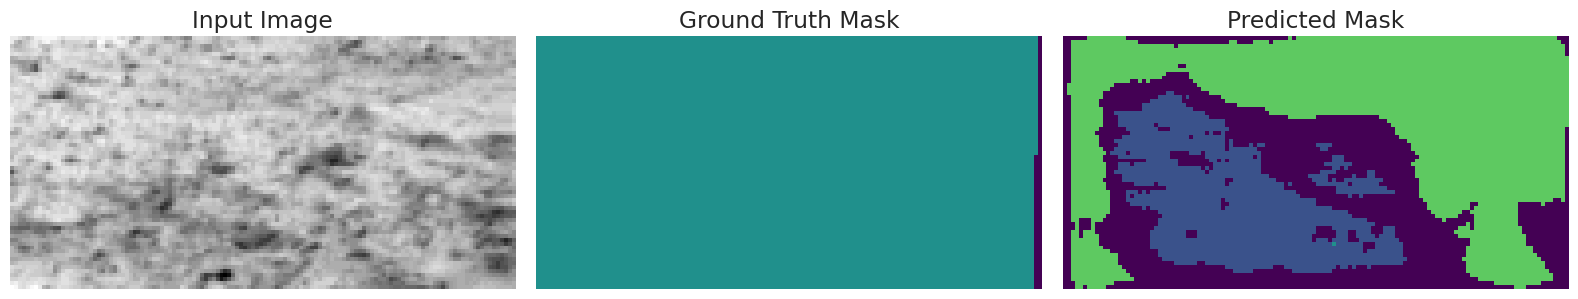

53/53 ━━━━━━━━━━━━━━━━━━━━ 155s 2s/step - class1: 0.0628 - class2: 0.3029 - class3: 0.4280 - class4: 0.0314 - loss: 0.4166 - mean_iou: 0.2015 - val_class1: 0.2002 - val_class2: 0.3223 - val_class3: 0.4687 - val_class4: 0.0913 - val_loss: 0.4139 - val_mean_iou: 0.2710
Epoch 2/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - class1: 0.3173 - class2: 0.3096 - class3: 0.4966 - class4: 0.0296 - loss: 0.4148 - mean_iou: 0.2701 - val_class1: 0.4322 - val_class2: 0.0908 - val_class3: 0.4184 - val_class4: 0.0468 - val_loss: 0.4143 - val_mean_iou: 0.2502
Epoch 3/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - class1: 0.4738 - class2: 0.3792 - class3: 0.5293 - class4: 0.0310 - loss: 0.4134 - mean_iou: 0.3300 - val_class1: 0.4516 - val_class2: 0.1792 - val_class3: 0.5406 - val_class4: 0.0523 - val_loss: 0.4130 - val_mean_iou: 0.3041
Epoch 4/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - class1: 0.5360 - class2: 0.4287 - class3: 0.5481 - class4: 0.0373 - loss: 0.4131 - mean_iou: 0.3640 - val_class1: 0.47

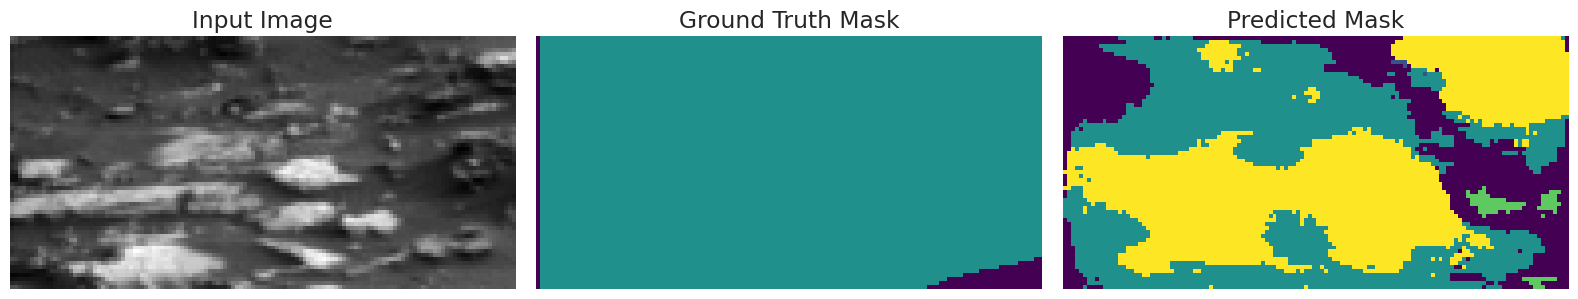

53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - class1: 0.5992 - class2: 0.4982 - class3: 0.5670 - class4: 0.0597 - loss: 0.4124 - mean_iou: 0.4075 - val_class1: 0.5269 - val_class2: 0.2989 - val_class3: 0.5622 - val_class4: 0.0041 - val_loss: 0.4128 - val_mean_iou: 0.3232
Epoch 7/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - class1: 0.5986 - class2: 0.5049 - class3: 0.5597 - class4: 0.0450 - loss: 0.4121 - mean_iou: 0.4010 - val_class1: 0.5453 - val_class2: 0.4179 - val_class3: 0.6145 - val_class4: 0.0390 - val_loss: 0.4118 - val_mean_iou: 0.3815
Epoch 8/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - class1: 0.6153 - class2: 0.5167 - class3: 0.5846 - class4: 0.0536 - loss: 0.4120 - mean_iou: 0.4167 - val_class1: 0.5711 - val_class2: 0.4783 - val_class3: 0.5305 - val_class4: 0.0305 - val_loss: 0.4113 - val_mean_iou: 0.3791
Epoch 9/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - class1: 0.6444 - class2: 0.5595 - class3: 0.6000 - class4: 0.0729 - loss: 0.4117 - mean_iou: 0.4467 - val_class1: 0.550

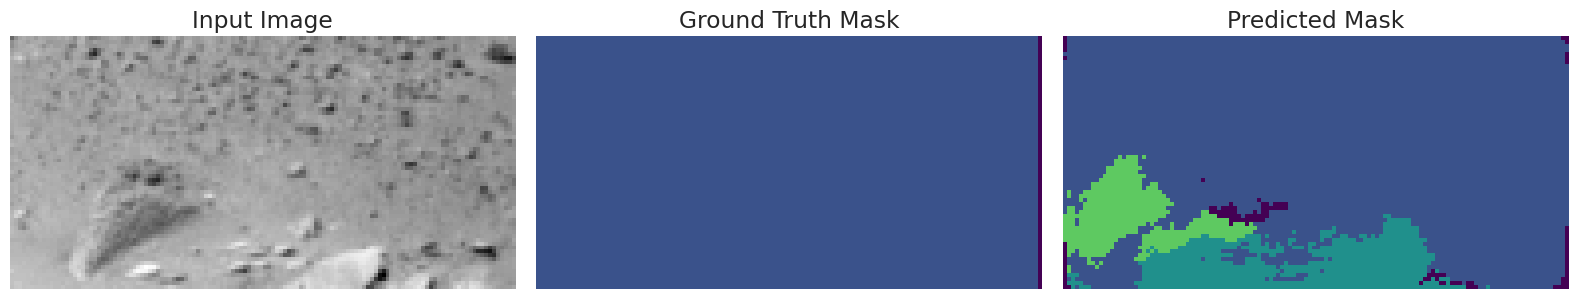

53/53 ━━━━━━━━━━━━━━━━━━━━ 93s 2s/step - class1: 0.6580 - class2: 0.5887 - class3: 0.6236 - class4: 0.0754 - loss: 0.4112 - mean_iou: 0.4604 - val_class1: 0.5763 - val_class2: 0.4709 - val_class3: 0.5688 - val_class4: 0.0461 - val_loss: 0.4116 - val_mean_iou: 0.3968
Epoch 12/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - class1: 0.6717 - class2: 0.6122 - class3: 0.6254 - class4: 0.1129 - loss: 0.4111 - mean_iou: 0.4886 - val_class1: 0.5718 - val_class2: 0.4948 - val_class3: 0.5442 - val_class4: 0.0737 - val_loss: 0.4119 - val_mean_iou: 0.4062
Epoch 13/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 92s 2s/step - class1: 0.6925 - class2: 0.6396 - class3: 0.6498 - class4: 0.1412 - loss: 0.4109 - mean_iou: 0.5165 - val_class1: 0.6018 - val_class2: 0.4449 - val_class3: 0.5383 - val_class4: 0.0202 - val_loss: 0.4122 - val_mean_iou: 0.3788
Epoch 14/1000
53/53 ━━━━━━━━━━━━━━━━━━━━ 91s 2s/step - class1: 0.6960 - class2: 0.6500 - class3: 0.6506 - class4: 0.1540 - loss: 0.4106 - mean_iou: 0.5218 - val_class1: 0.

In [ ]:
# Train the model
with strategy.scope():
    train_dataset = train_dataset.shuffle(buffer_size=10, seed=seed)

    history = model.fit(
        train_dataset,
        epochs=EPOCHS,
        validation_data=val_dataset,
        callbacks=[early_stopping, viz_callback],
        verbose=1,
        class_weight={0:1.0, 1:1.0, 2:1.0, 3:1.0, 4:10.0}
    ).history
    
    # Calculate and print the final validation accuracy
    final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
    print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

In [ ]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(model, test_data, class_names):
    """
    Plots the confusion matrix for the given model and test data.
    
    Args:
        model: Trained Keras model.
        test_data: A `tf.data.Dataset` or similar iterable with (inputs, labels).
        class_names: List of class names corresponding to the labels.
    """
    # Get ground-truth labels and model predictions
    y_true = []
    y_pred = []
    
    for inputs, labels in test_data:
        predictions = model.predict(inputs)
        y_true.extend(np.argmax(labels.numpy(), axis=-1))
        y_pred.extend(np.argmax(predictions, axis=-1))

    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    # Plot the confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
    plt.title("Confusion Matrix")
    plt.show()

plot_confusion_matrix(model, val_dataset, [0, 1,2,3,4])

In [ ]:
model.evaluate(val_dataset)

In [ ]:
preds = model.predict(X_test)
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

In [ ]:
import pandas as pd

def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

In [ ]:
from time import time

# Create and download the csv submission file
timestep_str = int(time())
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)